## installing...

In [ ]:
!pip install giotto-tda

In [ ]:
!pip install git+https://github.com/kieferk/pymssa.git

In [ ]:
!pip freeze

## importing...

In [3]:
from gtda.time_series import embedding, TakensEmbedding

In [4]:
import pandas as pd
import numpy as np


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import plotly.express as px

## loading data...

- Температура в Нью-Йорке
- Индекс Доу-Джонса


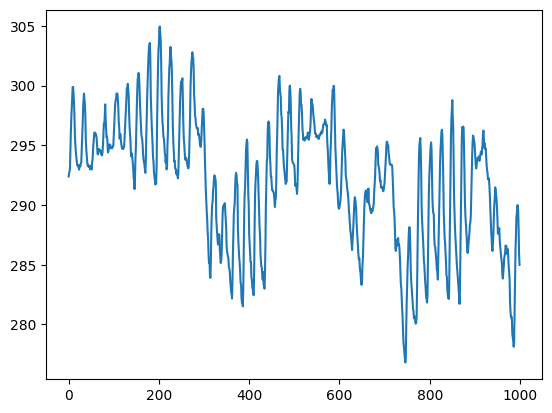

In [9]:
data_temp = pd.read_csv('temperature.csv')['New York'].dropna().values[-1000:]
plt.plot(data_temp)
plt.show()

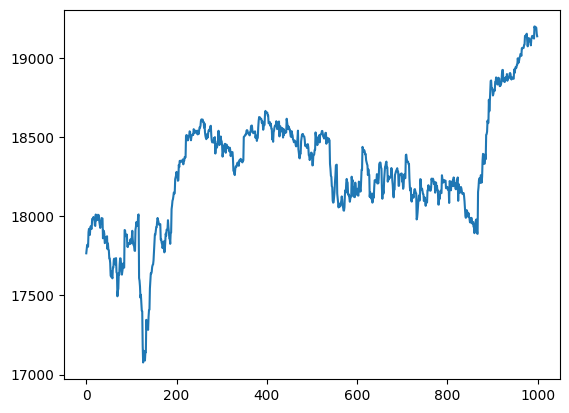

In [10]:
data_ind=pd.read_csv('/content/D&J-IND_150901_161130.txt')['<CLOSE>'].dropna().values[-1000:]
plt.plot(data_ind)
plt.show()

## Выполнение работы:
- Преобразование Фурье. (Изобразить диаграмму мощности гармоник, увидеть, чем периодический ряд отличается от хаотическогорю Use numpy.fft.fft)

In [19]:
def fft(data):
    freq = np.fft.fftfreq(len(data), d=0.01)
    mag =  2 * np.abs(np.fft.fft(data)) / len(data)

    return freq, mag

In [26]:
valid_i_ind=np.argmax(fft(data_ind)[0]<0)
valid_i_temp=np.argmax(fft(data_temp)[0]<0)

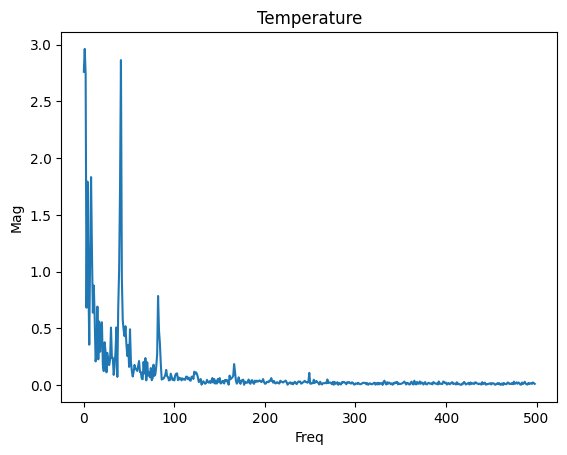

In [33]:
plt.plot(fft(data_temp)[1][1:valid_i_temp])
plt.title('Temperature')
plt.ylabel('Mag')
plt.xlabel('Freq')
plt.show()

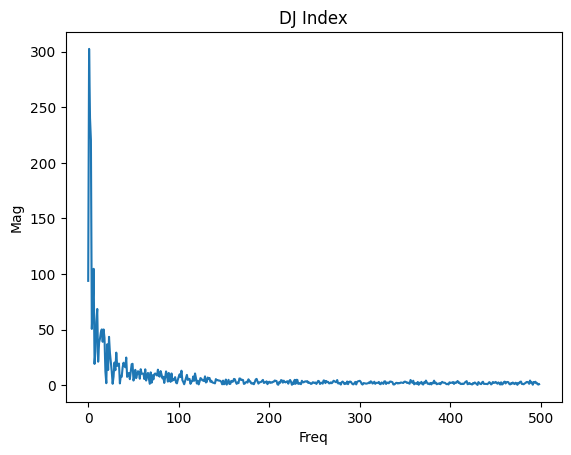

In [35]:
plt.plot(fft(data_ind)[1][1:valid_i_temp])
plt.title('DJ Index')
plt.ylabel('Mag')
plt.xlabel('Freq')
plt.show()

- Сингулярное спектральное разложение

In [39]:
from pymssa import MSSA

/usr/local/lib/python3.10/dist-packages/pymssa/mssa.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [81]:
#temperature
mssa_temp = MSSA(n_components=None,
            window_size=100,
            verbose=True)
mssa_temp.fit(data_temp)

Constructing trajectory matrix
Trajectory matrix shape: (100, 901)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


In [42]:
mssa_temp.component_ranks_[0:10].T[0]

array([ 0,  2, 11, 12,  9,  7,  5,  4, 14, 26])

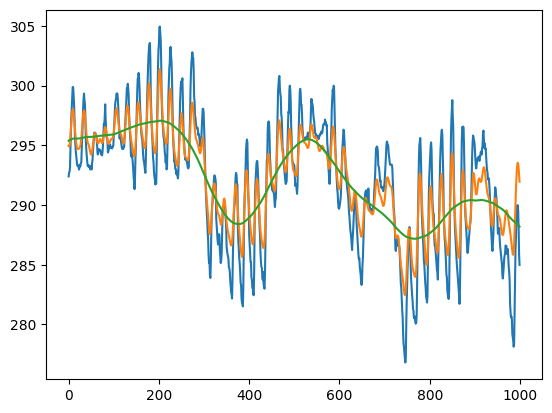

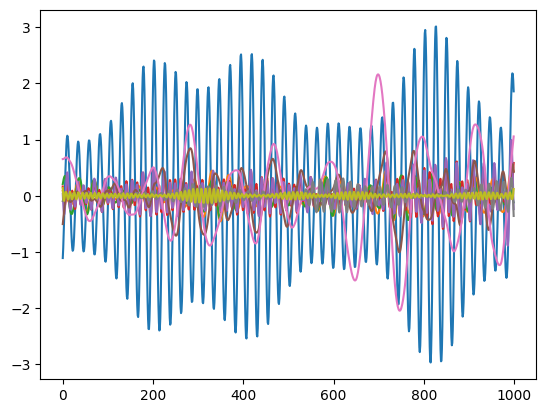

In [59]:
comp_temp = mssa_temp.components_[0].T[mssa_temp.component_ranks_[0:10].T[0]]
plt.plot(data_temp)
plt.plot(np.sum(comp_temp, axis=0))
plt.plot(comp_temp[0].T)
plt.show()
plt.plot(comp_temp[1:].T)
plt.show()

In [60]:
#DJ index
mssa_ind = MSSA(n_components=None,
            window_size=100,
            verbose=True)
mssa_ind.fit(data_ind)

Constructing trajectory matrix
Trajectory matrix shape: (100, 901)
Decomposing trajectory covariance matrix with SVD
Constructing components
Calculating optimal reconstruction orders


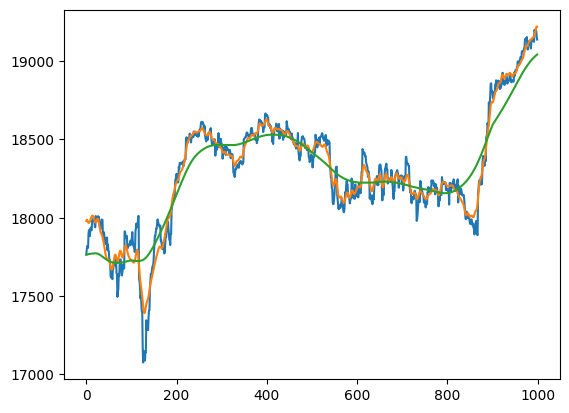

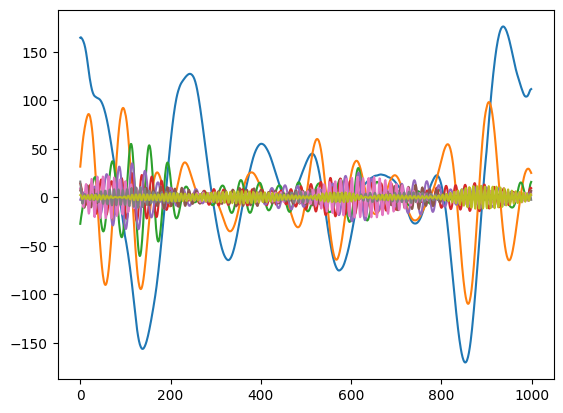

In [61]:
comp_ind = mssa_ind.components_[0].T[mssa_ind.component_ranks_[0:10].T[0]]
plt.plot(data_ind)
plt.plot(np.sum(comp_ind, axis=0))
plt.plot(comp_ind[0].T)
plt.show()
plt.plot(comp_ind[1:].T)
plt.show()

- Прогноз на несколько шагов с помощью SSA

In [107]:
from sklearn.metrics import mean_squared_error

Constructing trajectory matrix
Trajectory matrix shape: (476, 477)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 98 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders


Constructing trajectory matrix
Trajectory matrix shape: (476, 477)
Decomposing trajectory covariance matrix with SVD
Reduced rank to 79 according to SVHT threshold
Constructing components
Calculating optimal reconstruction orders
0


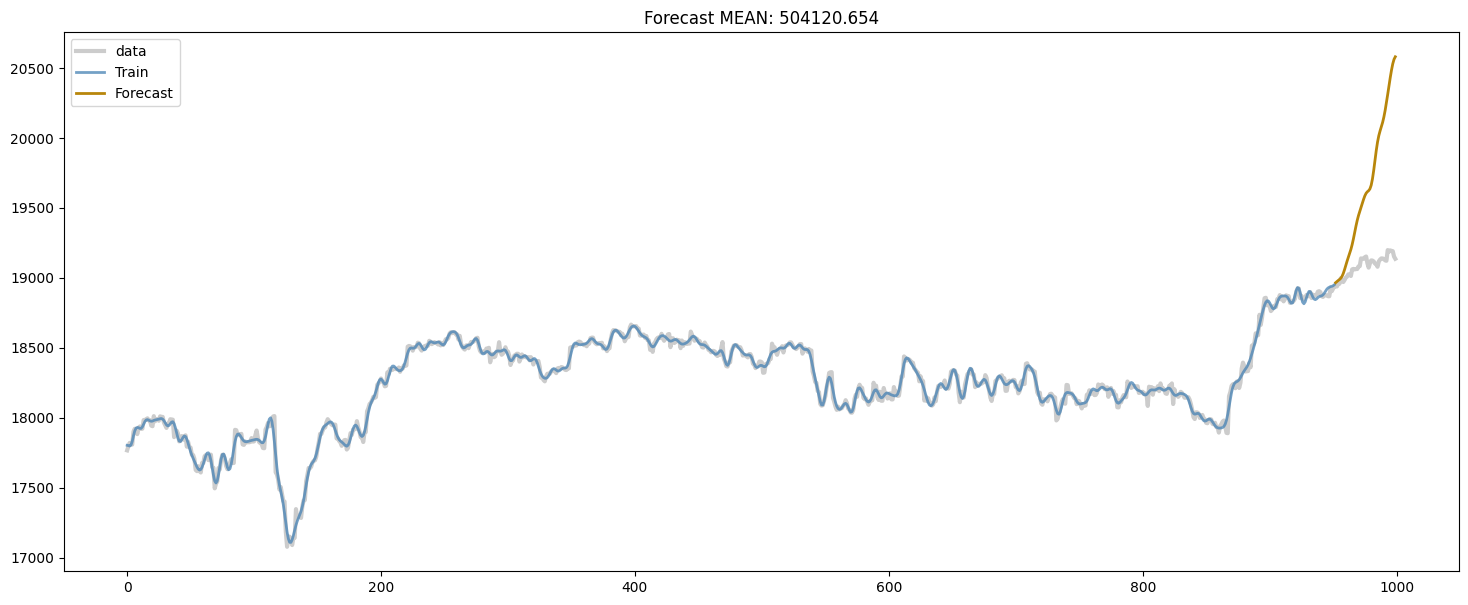

In [110]:
tp = 48
ind=pd.DataFrame({'data':data_ind})
ind_te = ind.iloc[-tp:]
ind_tr = ind.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=ind_tr
mssa.fit(x)
for ts_index in range(ind.shape[1]):
  print(ts_index)
  tr = np.zeros(ind.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = ind_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(ind.index, ind.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=temp.columns[ts_index])
  ax.plot(ind.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(ind.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

In [ ]:
tp = 48
temp=pd.DataFrame({'data':data_temp})
temp_te = temp.iloc[-tp:]
temp_tr = temp.iloc[:-tp]

mssa = MSSA(variance_explained_threshold=0.95,
            window_size=None,
            verbose=True)
x=temp_tr
mssa.fit(x)
for ts_index in range(temp.shape[1]):
  print(ts_index)
  tr = np.zeros(temp.shape[0])
  tr[:] = np.nan
  te = np.copy(tr)
  tr[:-tp] = mssa.components_[ts_index, :, :].sum(axis=1)
  fc = mssa.forecast(tp, timeseries_indices=ts_index)

  ytrue = temp_te.iloc[:, ts_index].values
  yhat = fc.ravel()[~pd.isnull(ytrue)]
  ytrue = ytrue[~pd.isnull(ytrue)]

  mean = mean_squared_error(ytrue, yhat)
  te[-tp:] = fc

  fig, ax = plt.subplots(figsize=(18, 7))
  ax.plot(temp.index, temp.iloc[:, ts_index].values, lw=3, alpha=0.2, c='k', label=temp.columns[ts_index])
  ax.plot(temp.index, tr, lw=2, c='steelblue', alpha=0.75, label='Train')
  ax.plot(temp.index, te, lw=2, c='darkgoldenrod', label='Forecast')
  ax.set_title(f'Forecast MEAN: {mean:.3f}')
  ax.legend()

  plt.show()

- Изображение автокорреляционных функций для обоих рядов.

In [111]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

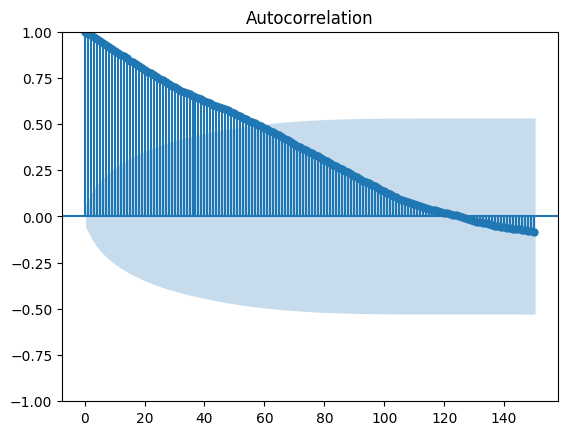

In [112]:
plot_acf(data_ind, lags=150)
plt.show()

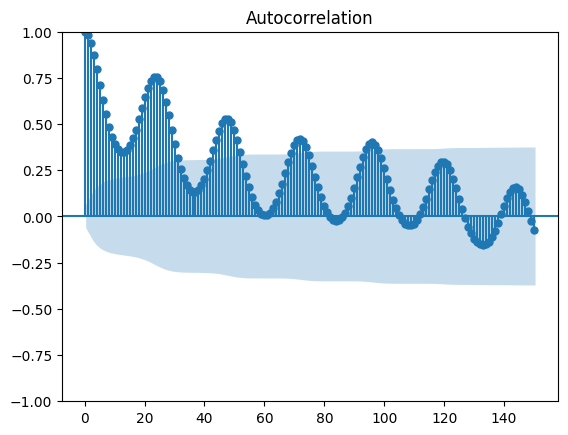

In [113]:
plot_acf(data_temp, lags=150)
plt.show()